# Vectorization

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer , TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import pickle

df=pd.read_csv("Clean_Data.csv")
df=df.drop(["Unnamed: 0"],axis=1)
df=df.dropna()

In [32]:
pipe = Pipeline([('count', CountVectorizer()), ('tfid', TfidfTransformer())]).fit(df["Clean_Content"])

pickle.dump(pipe, open("pipe.pkl", "wb"))




In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Clean_Content'], df['dialect'], test_size=0.1, stratify=df['dialect'],  random_state=42)

In [33]:
X_train_tfidf=pipe.transform(X_train)
X_test_tfidf=pipe.transform(X_test)

# ML model

In [12]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

y_pred=clf.predict(X_test_tfidf)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score , ConfusionMatrixDisplay
from sklearn import feature_extraction, manifold
import seaborn as sn
import matplotlib.pyplot as plt

In [14]:
def performance(y,y_predict,clf):
    print('Confusion Matrix\n')

    
    cm = confusion_matrix(y, y_predict, labels=clf)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm ,display_labels=clf)
    disp.plot()
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

    print('Classification Report\n')
    clf_report = classification_report(y,y_predict,
                                   labels=clf,
                                
                                   output_dict=True)
    plt.figure(figsize=(8.5, 8.5))
    sn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
    print(accuracy_score(y,y_predict))

Confusion Matrix



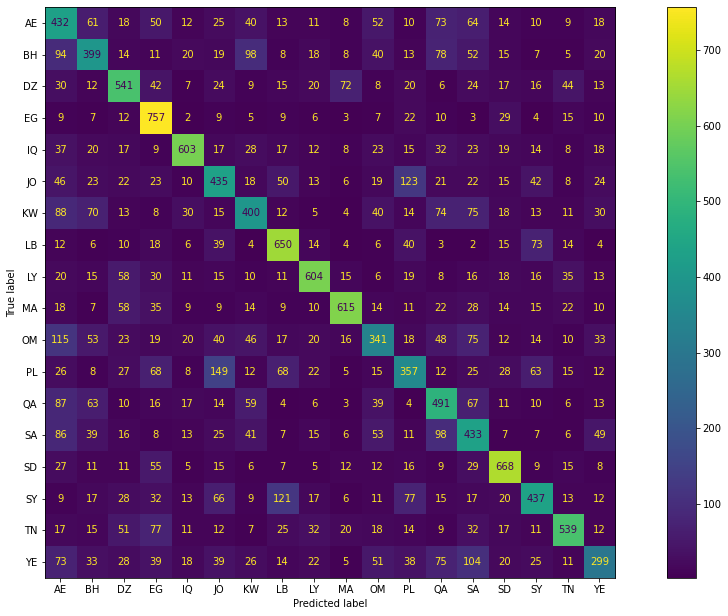

Classification Report

0.5436371323307363


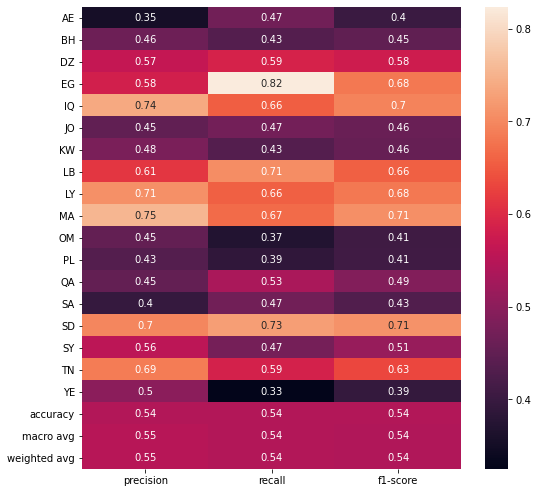

In [17]:
performance(y_test,y_pred,clf.classes_)

In [31]:
pickle.dump(clf, open("model.pkl", "wb"))

In [40]:
from flask import Flask, request, jsonify, render_template
import pickle
import re, emoji, string
import pyarabic.araby as ar

model = pickle.load(open("C:\\Users\\SaWa\\Untitled Folder\\model.pkl", "rb"))
pipe = pickle.load(open("C:\\Users\\SaWa\\Untitled Folder\\pipe.pkl", "rb"))

def data_cleaning(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)  # Removing all links
    text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"https\S+", "", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub("(\s\d+)", "", text)
    text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
    text = re.sub("\d+", " ", text)
    text = ar.strip_tashkeel(text)
    text = ar.strip_tatweel(text)
    text = text.replace("#", " ");
    text = text.replace("@", " ");
    text = text.replace("_", " ");
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = emoji.replace_emoji(text, replace="")  # removing emojis
    text = text.replace("آ", "ا")
    text = text.replace("إ", "ا")
    text = text.replace("أ", "ا")
    text = text.replace("ؤ", "و")
    text = text.replace("ئ", "ي")
    text = re.sub(r'[a-zA-Z]', '', text)  # removing all english chars
    text = re.sub(r'[^\w\s]', '', text)  # removing all punctuation
    return text

text1 =  ' ياخي المدرب اختاره والمدرب دخله والمدرب بارك الخطوه  منو هم اللي دخلوه الاتحاد قصدك  هذا منتخب مش نادي بارك الله فيك'
text = data_cleaning(text1)

trans_text = pipe.transform([text])
prediction = model.predict(trans_text)

# DL model

## Vectorization for deep learning model 

In [18]:
# reducing the number of features so as to keep reduce the computational cost 
def TFIDF(X_train, X_test,MAX_NB_WORDS=1000):
    vectorizer_x = TfidfVectorizer(max_features=MAX_NB_WORDS)
    X_train = vectorizer_x.fit_transform(X_train).toarray()
    X_test = vectorizer_x.transform(X_test).toarray()
    print("tf-idf with",str(np.array(X_train).shape[1]),"features")
    return (X_train,X_test)


X_train_tfidf,X_test_tfidf=TFIDF(X_train,X_test)

tf-idf with 1000 features


In [19]:
import tensorflow as tf 
from keras.layers import Dense , Activation , Dropout
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import cross_val_score
from tensorflow.keras.metrics import CategoricalAccuracy
from keras.metrics import Recall, Precision 

def reset_graph(seed=42): # to keep weights instantiation constant
    tf.compat.v1.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [20]:
encoder = LabelEncoder().fit(df['dialect'])
y_train_encoded= encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)


classes_no = len(np.unique(df['dialect']))


y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded,classes_no)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded,classes_no)

vector_size=X_train_tfidf.shape[1]

In [21]:
# For using the F1-score as a metric 

import keras.backend as K

def f1_metric(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

In [22]:
reset_graph(seed=7)
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Flatten(input_shape=(vector_size,)),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.2),
  
    tf.keras.layers.Dense(classes_no, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(classes_no, activation='sigmoid')
])

In [23]:
reset_graph(seed=7)
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy','Recall','Precision',f1_metric])

In [24]:
batch_size=100
epochs=10


history=model.fit(X_train_tfidf,
          y_train_categorical,
          epochs=epochs,
          verbose=1

          
          )

Epoch 1/10
4657/4657 [==============================] - 35s 7ms/step - loss: 2.2832 - accuracy: 0.2821 - recall: 0.7630 - precision: 0.1023 - f1_metric: 0.1810
Epoch 2/10
4657/4657 [==============================] - 35s 7ms/step - loss: 2.1097 - accuracy: 0.3331 - recall: 0.7979 - precision: 0.1121 - f1_metric: 0.1969
Epoch 3/10
4657/4657 [==============================] - 35s 7ms/step - loss: 2.0230 - accuracy: 0.3595 - recall: 0.8080 - precision: 0.1191 - f1_metric: 0.2080
Epoch 4/10
4657/4657 [==============================] - 35s 8ms/step - loss: 1.9287 - accuracy: 0.3902 - recall: 0.8120 - precision: 0.1282 - f1_metric: 0.2219
Epoch 5/10
4657/4657 [==============================] - 35s 8ms/step - loss: 1.8248 - accuracy: 0.4195 - recall: 0.8221 - precision: 0.1387 - f1_metric: 0.2378
Epoch 6/10
4657/4657 [==============================] - 35s 8ms/step - loss: 1.7169 - accuracy: 0.4521 - recall: 0.8310 - precision: 0.1485 - f1_metric: 0.2526
Epoch 7/10
4657/4657 [==================

In [25]:
h= model.predict(X_test_tfidf)
cc=classes_x=np.argmax(h,axis=1)

In [26]:
y_pred=encoder.inverse_transform(cc)

Confusion Matrix



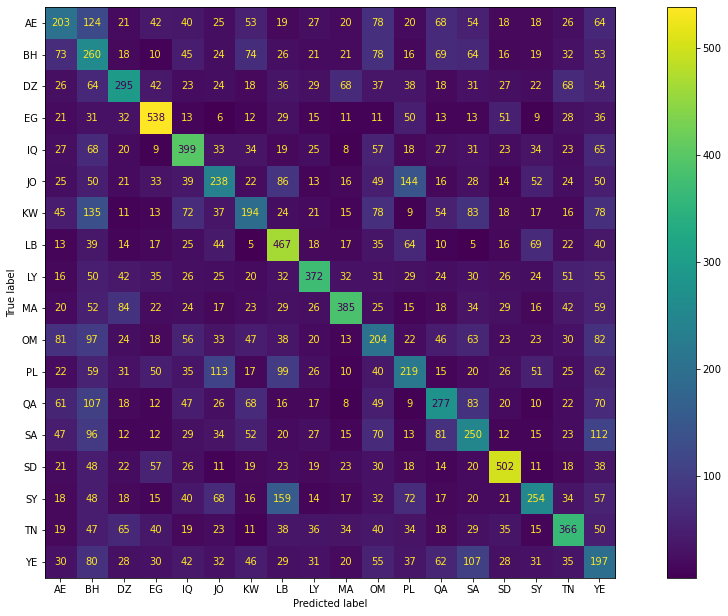

Classification Report

0.3394334722473878


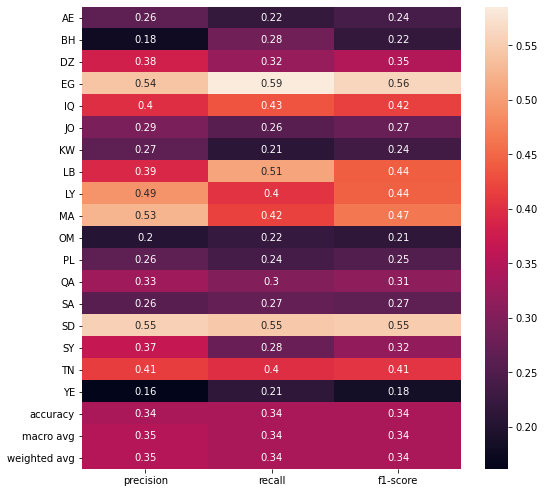

In [27]:
performance(y_test,y_pred,clf.classes_)